In [1]:
import torch
from torch import nn
from torchvision import datasets,transforms
from torchvision.models import vgg16_bn,VGG16_BN_Weights
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
trans=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.49,0.45,0.44],[0.29,0.27,0.25])
])

In [3]:
target_trans=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.PILToTensor()
])

In [4]:
train_data=datasets.VOCSegmentation(root='data',download=False,
                                    image_set='train',transform=trans,target_transform=target_trans,
                                    )
val_data=datasets.VOCSegmentation(root='data',download=False,
                                  image_set='val',transform=trans,target_transform=target_trans)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7129412..2.24].


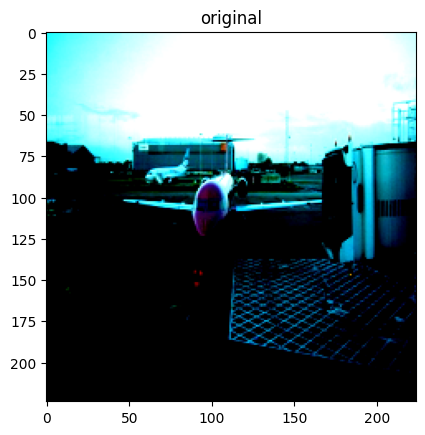

In [5]:
plt.imshow(train_data[0][0].permute(1,2,0))
plt.title('original')
plt.show()

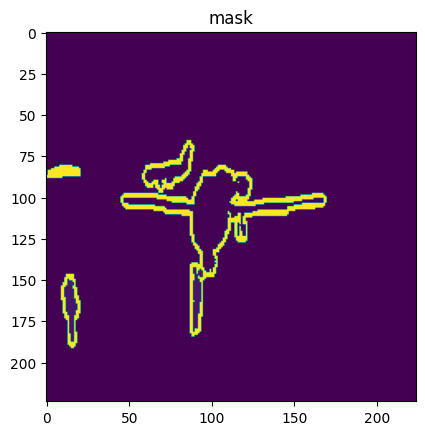

In [6]:
plt.imshow(train_data[0][1].permute(1,2,0))
plt.title('mask')
plt.show()

In [7]:
train_ds=DataLoader(dataset=train_data,shuffle=True,batch_size=32,num_workers=4)
val_ds=DataLoader(val_data,batch_size=32)

In [8]:
def try_gpu():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    return torch.device('cpu')

In [9]:
## 网络结构
class FCN8S(torch.nn.Module):
    def __init__(self,out_channels=21):
        super().__init__()
        self.backend=vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V1).features
        self.down1=self.backend[0:24]##32,3,28,28
        self.down2=self.backend[24:34]#32,3,14,14
        self.down3=self.backend[34:]#32,3,7,7
        self.conv3=nn.Sequential(
            nn.Conv2d(512,1024,kernel_size=1,padding=0,stride=1,padding_mode='reflect'),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        self.conv32=nn.Sequential(
            nn.Conv2d(1024,512,kernel_size=1,padding=0,stride=1,padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.up_3=nn.ConvTranspose2d(512,512,kernel_size=4,stride=2,padding=1)
        self.conv2=nn.Sequential(nn.Conv2d(512,512,kernel_size=1,padding=0,stride=1),
                                 nn.BatchNorm2d(512),
                                 nn.ReLU())
        self.up_2=nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1)
        self.conv1=nn.Sequential(nn.Conv2d(256,256,kernel_size=1,padding=0,stride=1),
                                 nn.BatchNorm2d(256),
                                 nn.ReLU())
        self.up_1=nn.ConvTranspose2d(256,out_channels,kernel_size=16,stride=8,padding=4)
    def forward(self,x):
        out_1=self.down1(x)
        out_2=self.down2(out_1)
        out_3=self.down3(out_2)

        out_3=self.conv3(out_3)
        out_3=self.conv32(out_3)
        out_3=self.up_3(out_3)
        out_2=self.conv2(out_2)

        out=out_2+out_3
        out=self.up_2(out)

        out_1=self.conv1(out_1)
        out = out + out_1

        out=self.up_1(out)
        return out

In [10]:
fcn=FCN8S()

In [11]:
## 检验输出大小
X=torch.randn(32,3,224,224)
fcn(X).shape

torch.Size([32, 21, 224, 224])

In [12]:
## 损失函数
class FocalLoss(nn.Module):
    def __init__(self,alpha=0.25,gamma=2,ignore_dix=255, *args, **kwargs,):
        super().__init__(*args, **kwargs)
        self.alpha=alpha
        self.gamma=gamma
        self.ignore_dix=ignore_dix
    def forward(self,inputs,targets):
        predict=inputs.permute(0,2,3,1).contiguous()
        predict=torch.softmax(predict,dim=-1)
        b,c=predict.size(0),predict.size(3)
        mask=targets!=self.ignore_dix#(batch_size,h,w)
        predict=predict[mask].view(-1,c)
        targets=targets[mask].view(-1)
        one_hot=torch.eye(c,device=predict.device)
        targets=one_hot[targets].view(-1,c).float()#(predict_size,c)
        FL=((-self.alpha*((1-predict)**self.gamma))*targets*torch.log2(predict+1e-12)).sum(dim=-1)#(predict_size,)
        return FL.mean()

In [13]:
## 定义累加器
class Accumulator():
    def __init__(self,n):
        self.data=[0.0]*n
    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]
    def reset(self):
        self.data=[0.0]*len(self.data)
    def __getitem__(self, item):
        return self.data[item]

In [30]:
## 定义训练函数
def train(net,train_iter,val_iter,lr,num_epochs,device=None,patience=10):
    # def init_weights(m):
    #     if isinstance(m,nn.Conv2d):
    #         nn.init.kaiming_normal(m.weight)
    # net.apply(init_weights)
    history=[]
    best_val_loss=1.29482e-01
    counter=0
    net.to(device)
    print('training on',device)
    loss=FocalLoss(ignore_dix=255)
    optimizer=torch.optim.Adam(net.parameters(),lr=lr,weight_decay=5e-4)
    batch_size=len(train_iter)
    for epoch in range(num_epochs):
        net.train()
        metric=Accumulator(2)
        print(f"epoch{epoch+1}")
        for i,(X,y) in enumerate(train_iter):
            X,y=X.to(device),y.to(device)
            y=y.squeeze(1).long()
            y_hat=net(X)
            l=loss(y_hat,y)
            optimizer.zero_grad()
            l.sum().backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l,l.numel())
            if (i+1)%(batch_size//5)==0 or i==batch_size-1:
                print(f'\tloss {metric[0]/metric[1]:.5e}')
        ## 验证模式
        net.eval()
        metric2=Accumulator(2)
        with torch.no_grad():
            for X,y in val_iter:
                X,y=X.to(device),y.to(device)
                y=y.squeeze(1).long()
                y_hat=net(X)
                l2=loss(y_hat,y)
                metric2.add(l2,l2.numel())
        print(f'epoch {epoch+1} summary: loss {metric[0]/metric[1]:.5e}, val_loss {metric2[0]/metric2[1]:.5e}')
        if metric2[0]/metric2[1]<best_val_loss:
            best_val_loss=metric2[0]/metric2[1]
            torch.save(net.state_dict(),'model_best.pth')
        else:
            counter+=1
            if counter>=patience:
                print('early stops')
                break
        print(f"best val_loss {best_val_loss:.5e}")
        history.append(metric[0]/metric[1])
    return history

In [46]:
## 开始训练！
history=train(fcn,train_ds,val_ds,lr=1e-6,num_epochs=40,device=try_gpu())

training on cuda
epoch1
	loss 9.92584e-03
	loss 9.57862e-03
	loss 9.77686e-03
	loss 9.75122e-03
	loss 9.78527e-03
	loss 1.00909e-02
epoch 1 summary: loss 1.00909e-02, val_loss 1.35526e-01
best val_loss 1.29482e-01
epoch2
	loss 1.02589e-02
	loss 1.01336e-02
	loss 1.00339e-02
	loss 9.92526e-03
	loss 9.80988e-03
	loss 9.79068e-03
epoch 2 summary: loss 9.79068e-03, val_loss 1.31509e-01
best val_loss 1.29482e-01
epoch3
	loss 1.06126e-02
	loss 9.59607e-03
	loss 9.64055e-03
	loss 9.53643e-03
	loss 9.59234e-03
	loss 9.61055e-03
epoch 3 summary: loss 9.61055e-03, val_loss 1.34273e-01
best val_loss 1.29482e-01
epoch4
	loss 1.06260e-02
	loss 1.02635e-02
	loss 1.00067e-02
	loss 9.90342e-03
	loss 9.78569e-03
	loss 9.77075e-03
epoch 4 summary: loss 9.77075e-03, val_loss 1.31581e-01
best val_loss 1.29482e-01
epoch5
	loss 1.03567e-02
	loss 1.03522e-02
	loss 9.94191e-03
	loss 9.94587e-03
	loss 9.72512e-03
	loss 9.78426e-03
epoch 5 summary: loss 9.78426e-03, val_loss 1.33555e-01
best val_loss 1.29482e-0

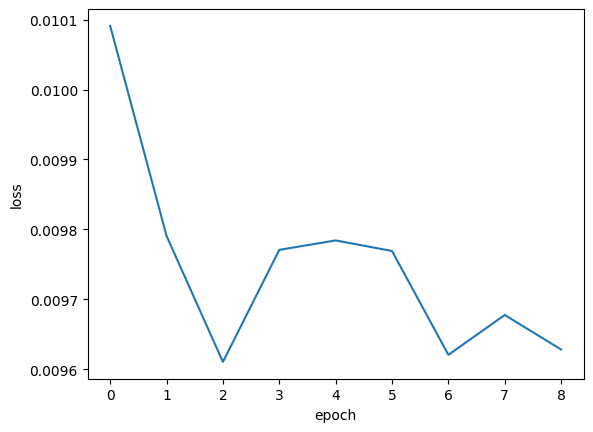

In [47]:
plt.plot(history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 在验证集上测试模型

In [48]:
## 定义预测函数
def predict(net,data_iter,num=15,idx=2):
    iters=iter(data_iter)
    for j in range(idx-1):
        next(iters)
    image,target=next(iters)
    images,targets=[],[]
    net.to(try_gpu())
    net.eval()
    with torch.no_grad():
        pred=net(image.to(try_gpu()))
    for i in range(num):
        images.append(image[i].permute(1,2,0).detach().cpu())
        targets.append(target[i].permute(1,2,0).detach().cpu())
    return images,targets,pred

In [79]:
origin,targets,preds=predict(fcn,val_ds,idx=4)

In [80]:
predicted=preds.argmax(1)
predicted.shape

torch.Size([32, 224, 224])

In [81]:
preds=[predicted[i].detach().cpu() for i in range(15)]
len(preds)

15

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7129412..2.0988235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7443137..2.177255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.76..2.24].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.76..2.24].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5560784..2.24].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7129412..2.2086275].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2839757..2.2243137].
Clipping in

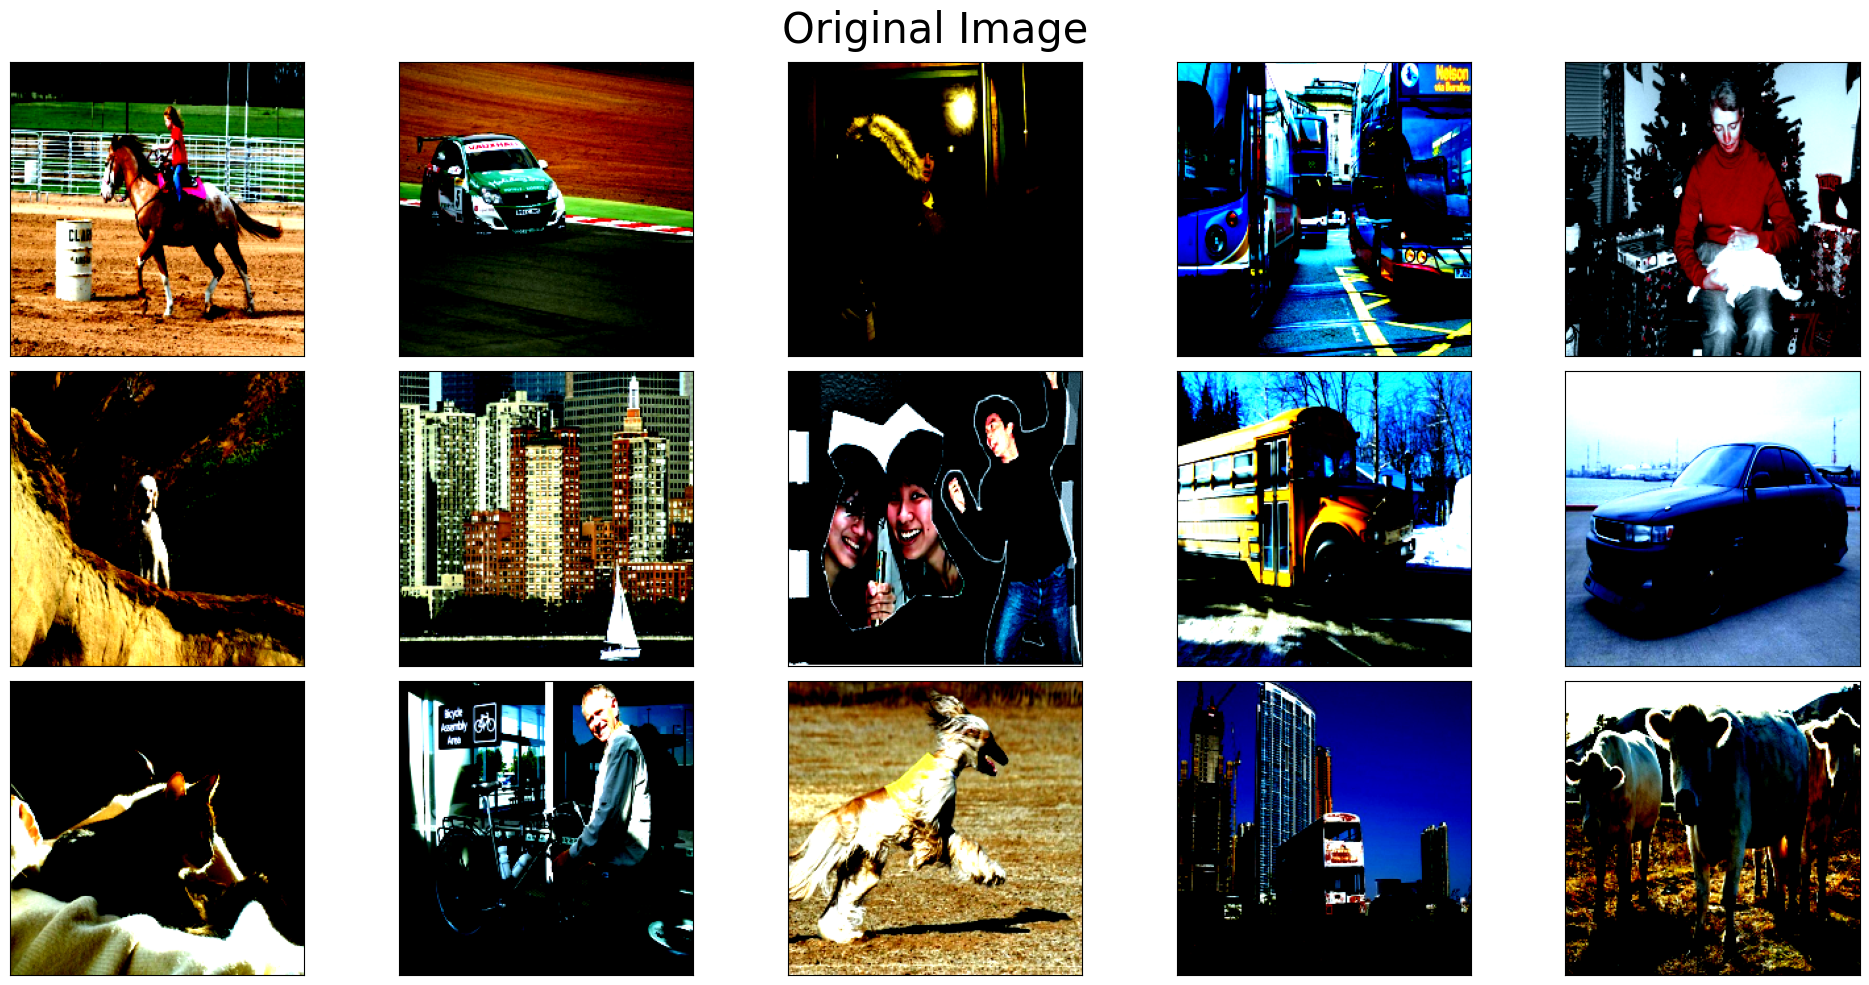

In [82]:
fig,axes=plt.subplots(3,5,figsize=(20,10))
for i in range(3):
    for j in range(5):
        axes[i,j].imshow(origin[j+i*5])
        axes[i,j].set_xticks(())
        axes[i,j].set_yticks(())
plt.suptitle('Original Image',fontsize=30)
fig.tight_layout()
plt.show()

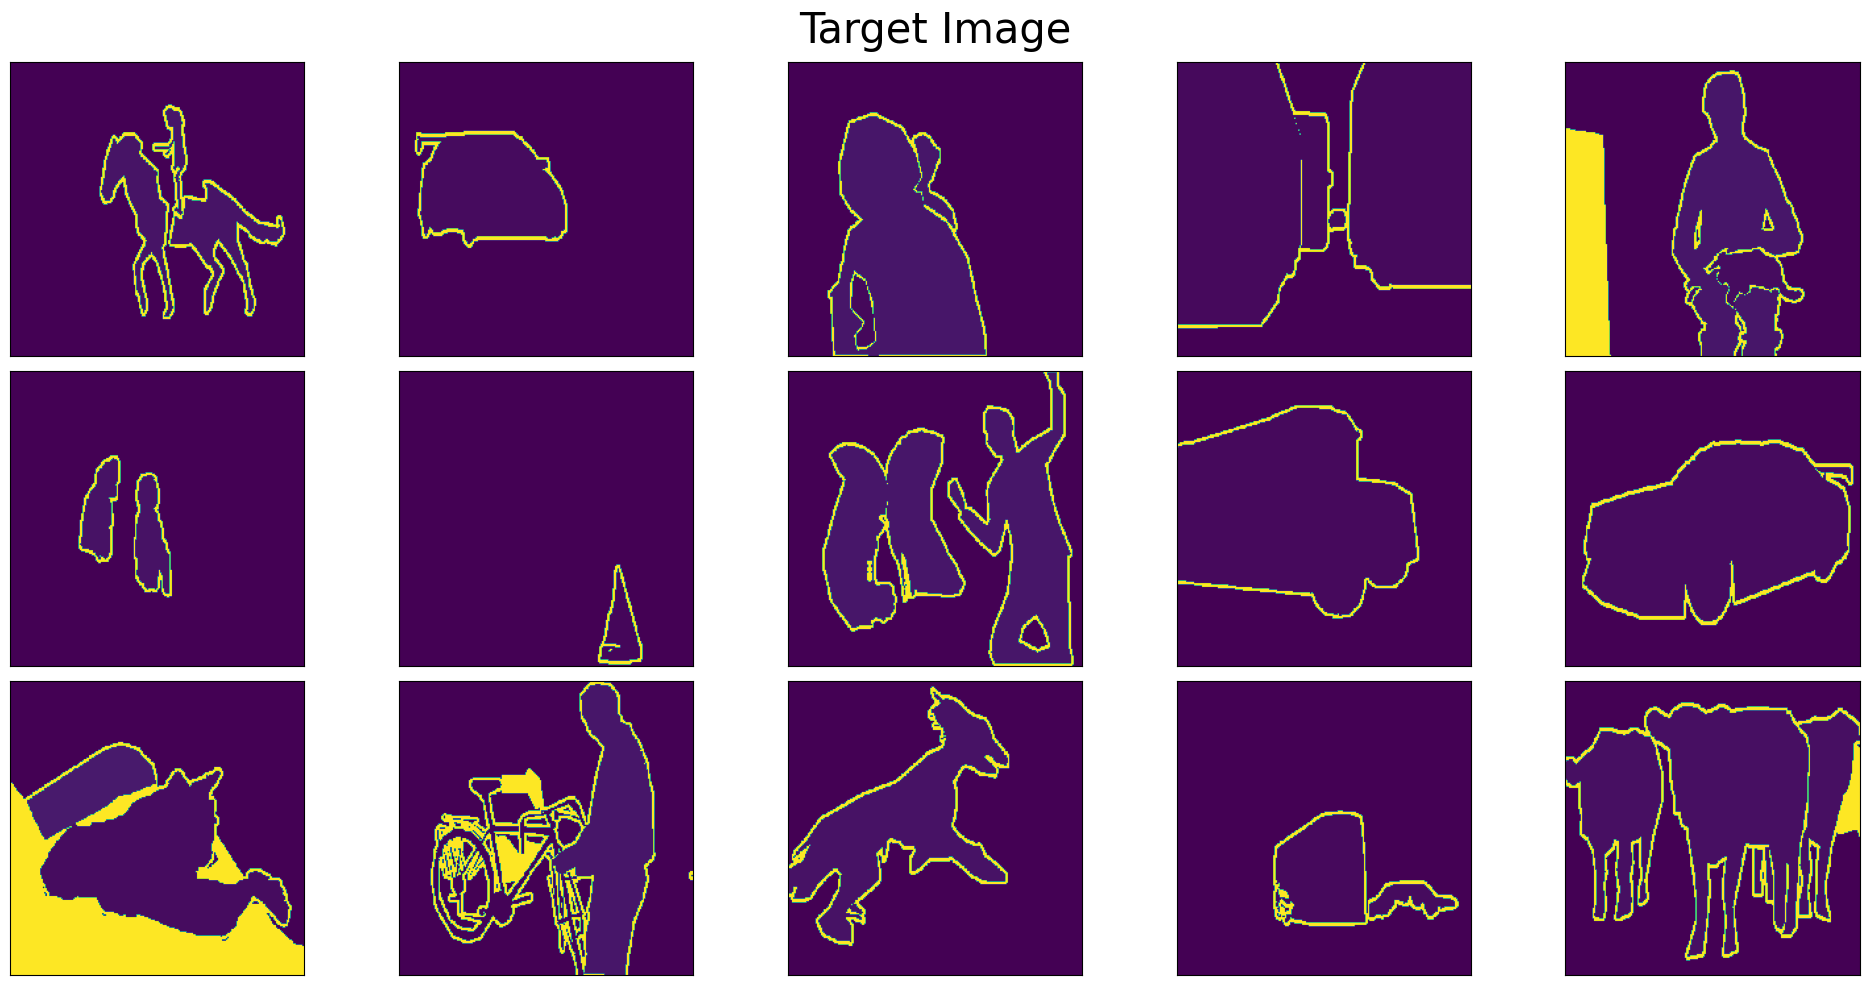

In [83]:
fig,axes=plt.subplots(3,5,figsize=(20,10))
for i in range(3):
    for j in range(5):
        axes[i,j].imshow(targets[j+i*5])
        axes[i,j].set_xticks(())
        axes[i,j].set_yticks(())
plt.suptitle('Target Image',fontsize=30)
fig.tight_layout()
plt.show()

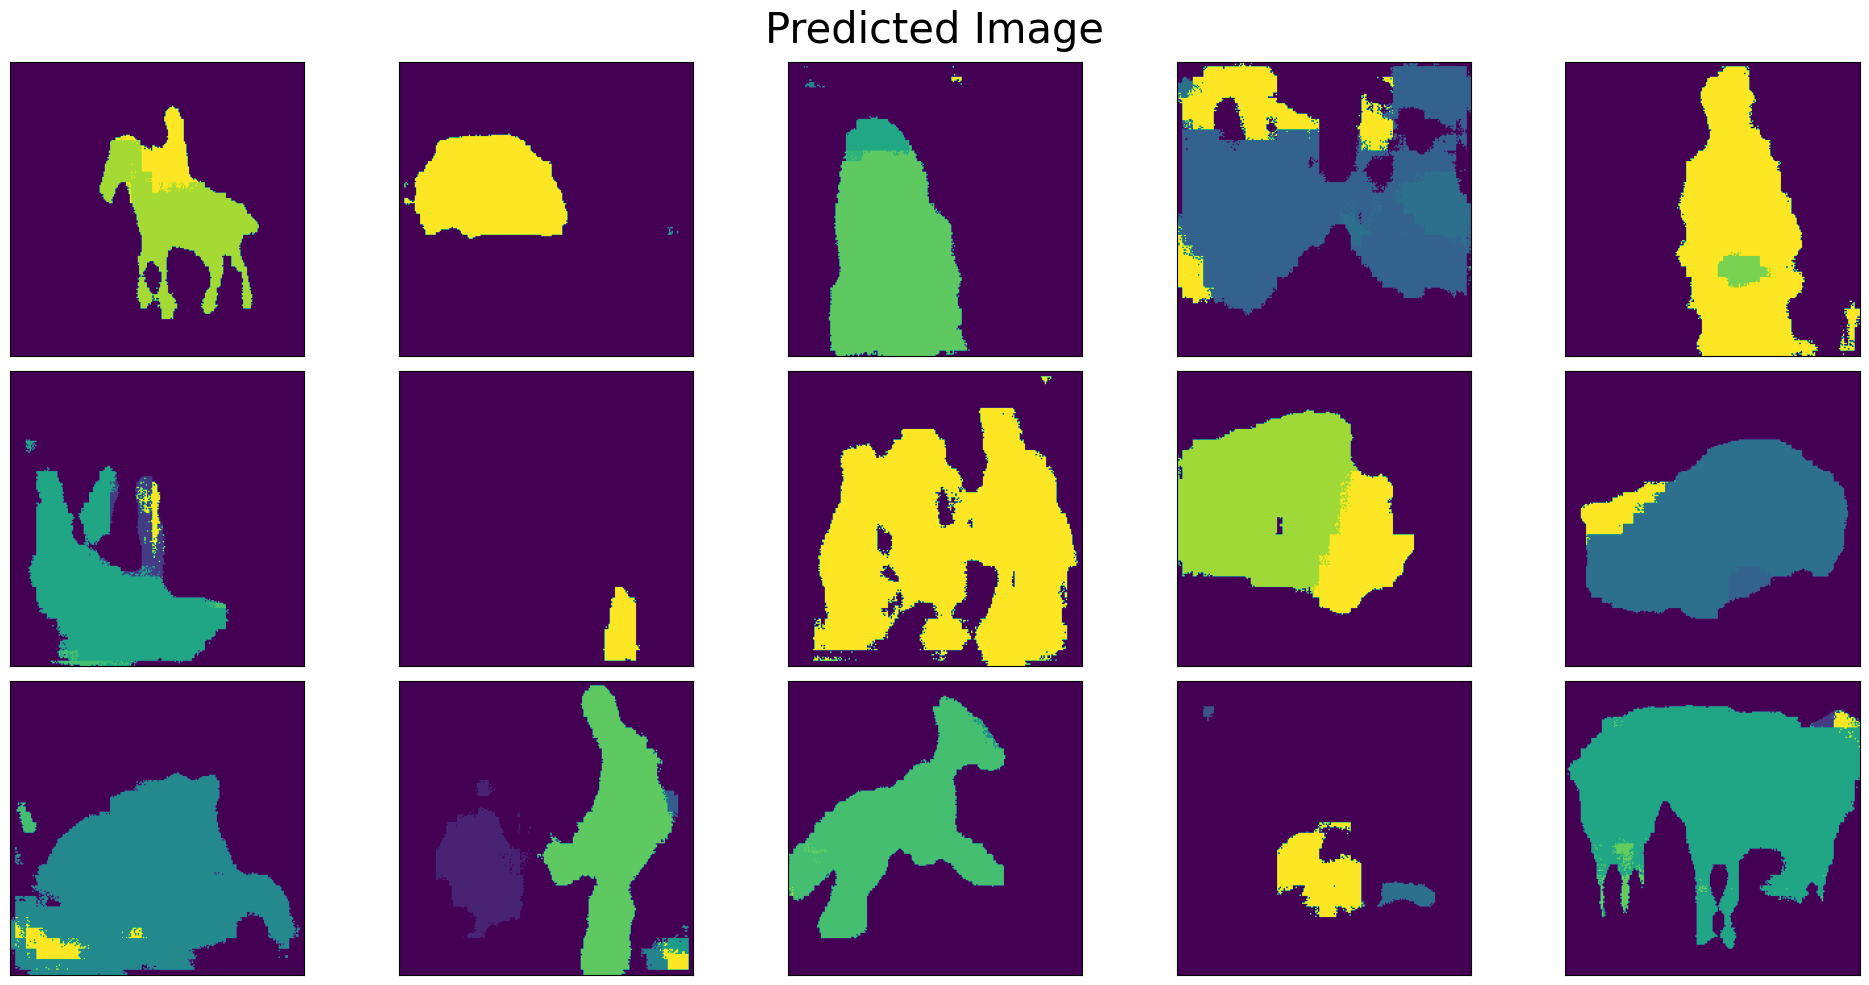

In [84]:
fig,axes=plt.subplots(3,5,figsize=(20,10))
for i in range(3):
    for j in range(5):
        axes[i,j].imshow(preds[j+i*5])
        axes[i,j].set_xticks(())
        axes[i,j].set_yticks(())
plt.suptitle('Predicted Image',fontsize=30)
fig.tight_layout()
plt.show()